In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# Dataset

In [2]:
df=pd.read_csv('df_cleaned.csv')
df

,Unnamed: 0,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0,37,Female,United States,No_data,No,1,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,1,44,Male,United States,No_data,No,0,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,2,32,Male,Canada,No_data,No,0,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,3,31,Male,United Kingdom,No_data,Yes,1,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,4,31,Male,United States,No_data,No,0,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,1254,26,Male,United Kingdom,No,No,1,No_data,26-100,No,...,Don't know,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No
1200,1255,32,Male,United States,No,Yes,1,Often,26-100,Yes,...,Yes,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No
1201,1256,34,Male,United States,No,Yes,1,Sometimes,More than 1000,No,...,Don't know,Somewhat difficult,Yes,Yes,No,No,No,No,No,No
1202,1257,46,Female,United States,No,No,0,No_data,100-500,Yes,...,Don't know,Don't know,Yes,No,No,No,No,No,No,No


# Data Insights

In [3]:
df.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Country', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

In [4]:
df.isna().sum()

Unnamed: 0                   0
Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 1204 non-null   int64 
 1   Age                        1204 non-null   int64 
 2   Gender                     1204 non-null   object
 3   Country                    1204 non-null   object
 4   self_employed              1204 non-null   object
 5   family_history             1204 non-null   object
 6   treatment                  1204 non-null   int64 
 7   work_interfere             1204 non-null   object
 8   no_employees               1204 non-null   object
 9   remote_work                1204 non-null   object
 10  tech_company               1204 non-null   object
 11  benefits                   1204 non-null   object
 12  care_options               1204 non-null   object
 13  wellness_program           1204 non-null   object
 14  seek_hel

In [6]:
df.describe()

,Unnamed: 0,Age,treatment
count,1204.000000,1204.000000,1204.000000
mean,629.997508,32.056478,0.500831
std,364.413980,7.338630,0.500207
min,0.000000,5.000000,0.000000
25%,311.750000,27.000000,0.000000
50%,633.500000,31.000000,1.000000
75%,945.250000,36.000000,1.000000
max,1258.000000,72.000000,1.000000


# Feature Engineering

In [7]:

df.drop('Unnamed: 0',axis=1,inplace=True)
df['leave']=df['leave'].map({'Very difficult': 0,'Somewhat difficult': 1,"Don't know": 2,'Somewhat easy': 3,'Very easy': 4})
df['risk_score']= df['family_history'].map({'Yes':1,'No':0})+df['mental_health_consequence'].map({'Yes':2,'No':0,"Don't know":1})+df['mental_vs_physical'].map({'Yes':2,'No':0,"Don't know":1})
df['Support']=df['benefits'].map({'Yes':1,'No':0,"Don't know":0.5})+df['care_options'].map({'Yes':1,'No':0,"Not sure":0.5})+df['wellness_program'].map({'Yes':1,'No':0,"Don't know":0.5})+df['leave']

<Axes: >

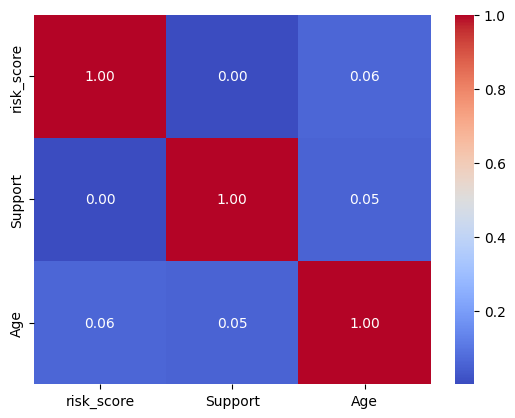

In [8]:
sns.heatmap(df[['risk_score','Support','Age']].corr(),annot=True,cmap='coolwarm',fmt='.2f')

# XGB Regressor

### Preprocessing

In [9]:
encode_cols=list(df.select_dtypes(include='object').columns)
pipeline=Pipeline([
    ("preprocess",ColumnTransformer([
        ('encode',OneHotEncoder(handle_unknown='ignore'),encode_cols)
        ]),
    ),
('Train',XGBRegressor())
])
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Country',
                                                   'self_employed',
                                                   'family_history',
                                                   'work_interfere',
                                                   'no_employees',
                                                   'remote_work',
                                                   'tech_company', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'seek_help', 'anonymity',
                                                   'mental_health_consequence',
                                                   'phys_health_consequence',
                                                   'c...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

### Model Training

In [10]:
x=df.drop('Age',axis=1)
y=df['Age']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


param_grid = {
    'Train__n_estimators': randint(200, 600),              
    'Train__learning_rate': uniform(0.01, 0.1),            
    'Train__max_depth': randint(3, 10),                    
    'Train__subsample': uniform(0.6, 0.4),                      
    'Train__gamma': uniform(0, 5),                         
    'Train__reg_alpha': uniform(0, 1),                     
    'Train__reg_lambda': uniform(0, 1)                 
}


### Model Evaluation

In [11]:
random_search=RandomizedSearchCV(estimator=pipeline,
                                 param_distributions=param_grid,
                                 cv=5,
                                 scoring='r2',
                                 n_jobs=-1,
                                 n_iter=200,
                                 random_state=42)
random_search.fit(x_train,y_train)
y_pred=random_search.predict(x_test)
print(random_search.best_params_)
print('R2 Score',r2_score(y_test,y_pred))
print('Mean Squared Error',mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error',mean_squared_error(y_test,y_pred))
print('Mean Absolute Error',mean_absolute_error(y_test,y_pred))
model = random_search.best_estimator_.named_steps['Train']
importances = model.feature_importances_
print("Feature Importances:",importances)

{'Train__gamma': np.float64(0.5940895813403596), 'Train__learning_rate': np.float64(0.02175262467771049), 'Train__max_depth': 3, 'Train__n_estimators': 200, 'Train__reg_alpha': np.float64(0.681039427096909), 'Train__reg_lambda': np.float64(0.23750647129246993), 'Train__subsample': np.float64(0.76008915714881)}
R2 Score 0.12210196256637573
Mean Squared Error 46.99448776245117
Root Mean Squared Error 46.99448776245117
Mean Absolute Error 5.352255344390869
Feature Importances: [0.01698375 0.         0.01020659 0.0122528  0.009312   0.00892122
 0.01048915 0.01634114 0.01381622 0.02665507 0.01524333 0.00765462
 0.01215802 0.0107536  0.         0.02270921 0.01881829 0.01907726
 0.00992468 0.01473421 0.0149716  0.01105975 0.01318265 0.014709
 0.01381086 0.02395804 0.02670777 0.         0.01446877 0.
 0.02132709 0.01118466 0.0240697  0.01269617 0.01619313 0.01324974
 0.0168926  0.01429866 0.02186675 0.01488398 0.01518627 0.03665951
 0.01414871 0.01128697 0.00896585 0.02128345 0.01549073 0.0136

### Important Features

Text(0.5, 1.0, 'Top 10 important Features')

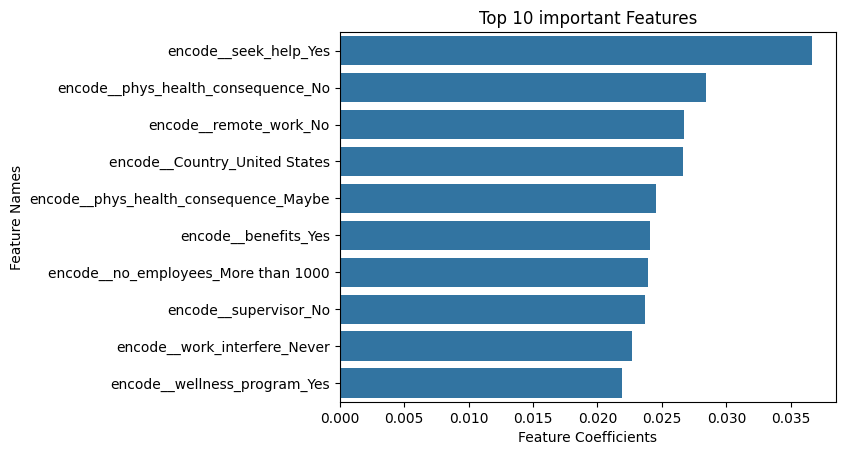

In [12]:
sorted_importance=np.argsort(importances)[::-1]
sorted_importance=sorted_importance[0:10]

feature = random_search.best_estimator_.named_steps['preprocess'].get_feature_names_out()
sns.barplot(y=feature[sorted_importance],x=importances[sorted_importance])
plt.xlabel("Feature Coefficients")
plt.ylabel("Feature Names")
plt.title("Top 10 important Features")

# Random Forest Regressor

### Preprocessing

In [13]:
encode_cols=list(df.select_dtypes(include='object').columns)
pipeline=Pipeline([
    ("preprocess",ColumnTransformer([
        ('encode',OneHotEncoder(handle_unknown='ignore'),encode_cols)
        ]),
    ),
('Train',RandomForestRegressor(n_jobs=-1))
])
pipeline


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Country',
                                                   'self_employed',
                                                   'family_history',
                                                   'work_interfere',
                                                   'no_employees',
                                                   'remote_work',
                                                   'tech_company', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'seek_help', 'anonymity',
                                                   'mental_health_consequence',
                                                   'phys_health_consequence',
                                                   'coworkers', 'supervisor',
                                                   'mental_health_interview',
                                                   'phys_health_interview',
                                                   'mental_vs_physical',
                                                   'obs_consequence'])])),
                ('Train', RandomForestRegressor(n_jobs=-1))])

### Model Training

In [14]:
x=df.drop('Age',axis=1)
y=df['Age']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


param_grid = {
    'Train__n_estimators': randint(200, 500),
    'Train__min_samples_leaf': randint(1, 6),
    'Train__max_depth': randint(3, 7),
    'Train__min_samples_split': randint(2, 10),
    'Train__max_features': ['sqrt', 'log2']
}

### Model Evaluation

In [15]:
random_search=RandomizedSearchCV(estimator=pipeline,
                                 param_distributions=param_grid,
                                 cv=5,
                                 scoring='r2',
                                 n_jobs=-1,
                                 n_iter=200,
                                 random_state=42)
random_search.fit(x_train,y_train)
y_pred=random_search.predict(x_test)
print(random_search.best_params_)
print('R2 Score',r2_score(y_test,y_pred))
print('Mean Squared Error',mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error',mean_squared_error(y_test,y_pred))
print('Mean Absolute Error',mean_absolute_error(y_test,y_pred))
model = random_search.best_estimator_.named_steps['Train']
importances = model.feature_importances_
print("Feature Importances:",importances)

{'Train__max_depth': 6, 'Train__max_features': 'sqrt', 'Train__min_samples_leaf': 1, 'Train__min_samples_split': 9, 'Train__n_estimators': 216}
R2 Score 0.10465560130525586
Mean Squared Error 47.92840335896779
Root Mean Squared Error 47.92840335896779
Mean Absolute Error 5.379571550670632
Feature Importances: [0.02430652 0.01908895 0.00586118 0.01175368 0.00214389 0.00271154
 0.00321486 0.00882397 0.01077982 0.04041614 0.0135193  0.00399401
 0.0113865  0.01066237 0.01016572 0.01552507 0.01474854 0.01122593
 0.01129573 0.00989413 0.01072428 0.00867394 0.01011034 0.0132391
 0.01184478 0.02332065 0.05113498 0.03772725 0.01558401 0.01345263
 0.0243938  0.00919106 0.03440758 0.01294242 0.01235417 0.01947543
 0.01427883 0.01134313 0.02750672 0.01259234 0.01615051 0.0538874
 0.00878721 0.00485162 0.00993905 0.00837398 0.01210522 0.01176756
 0.02179925 0.02614679 0.00751459 0.01136536 0.00910365 0.00816767
 0.0150671  0.01087655 0.00919084 0.01750718 0.0100635  0.0076249
 0.01164428 0.01689719

### Important Features

Text(0.5, 1.0, 'Top 10 important Features')

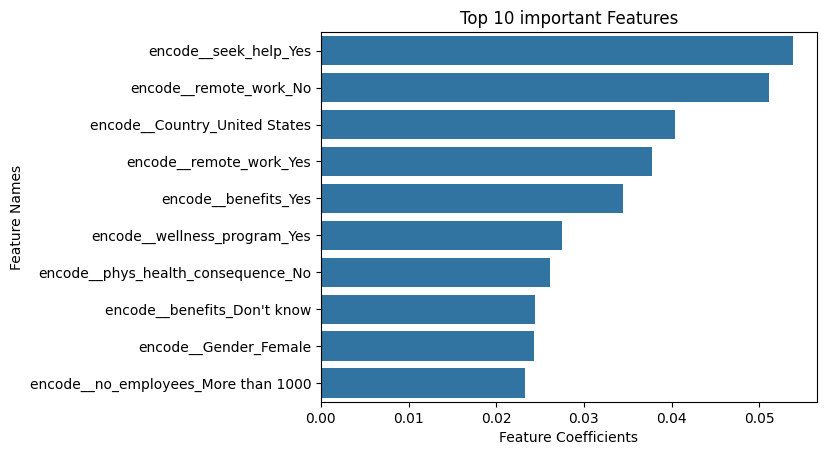

In [16]:
sorted_importance=np.argsort(importances)[::-1]
sorted_importance=sorted_importance[0:10]

feature = random_search.best_estimator_.named_steps['preprocess'].get_feature_names_out()
sns.barplot(y=feature[sorted_importance],x=importances[sorted_importance])
plt.xlabel("Feature Coefficients")
plt.ylabel("Feature Names")
plt.title("Top 10 important Features")